In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from scipy import stats

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
layer = 4
env_steps = Concept.load_concept_data()
actions = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']

In [4]:
model_path = QNetwork.find_newest_model()
#model_path = "runs/20240317-112025_task_0/model_10000000.pt"
model = QNetwork(model_path=model_path)

Loaded model: 20240322-100656_task_0-5000000


In [5]:
def get_cav(concept):
    concept.prepare_data(env_steps, max_size=10000)
    probe, info = train_probes(model, concept, hyperparameters, [layer])
    # score = info[layer]['test_score'][-1]
    probe = probe[layer]

    CAV = probe[1].weight.data.cpu().numpy().squeeze()
    CAV = torch.tensor(CAV, dtype=torch.float32)
    
    return CAV

In [6]:
def get_gradients(concept, CAV):
    # Get Q-values and test activations
    _, acts_dict = model(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]
    
    # Additional forward pass (return_acts=True detaches from graph)
    acts.requires_grad_(True)
    q_values = model.network[layer + 1:](acts)

    # Tensor to store gradients
    gradients = torch.zeros_like(q_values)

    # Compute gradients for each action
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        grads_flat = acts.grad.reshape(acts.shape[0], -1)
        # Dot with CAV (as in TCAV paper equation)
        gradients[:, j] = torch.mv(grads_flat, CAV)
    
    acts.grad.zero_()

    return gradients

In [7]:
def get_TCAV(gradients):
    TCAV = sum(gradients > 0) / gradients.shape[0]
    return TCAV.cpu().numpy()

In [8]:
def get_TCAVs(concept):
    if concept.binary:
        concept_random = concept_instances['random binary']
    else:
        concept_random = concept_instances['random continuous']
    actual_TCAVs = []
    random_TCAVs = []
    for i in tqdm.tqdm(range(100)):
        CAV = get_cav(concept)
        gradients = get_gradients(concept, CAV)
        actual_TCAVs.append(get_TCAV(gradients))
        
        CAV = get_cav(concept_random)
        gradients = get_gradients(concept, CAV)
        random_TCAVs.append(get_TCAV(gradients))
    return actual_TCAVs, random_TCAVs

In [9]:
def metric_significant(actual_metrics, random_metrics):
    result = stats.ttest_ind(actual_metrics, random_metrics, equal_var=False)
    return result.pvalue < 0.05

In [10]:
def get_metrics(concept):
    actual_TCAVs, random_TCAVs = get_TCAVs(concept)
    action_means = []
    for i in range(len(actions)):
        action_means.append(np.mean([TCAV[i] for TCAV in actual_TCAVs]))
    actual_TCAVs = [np.mean(TCAV) for TCAV in actual_TCAVs]
    random_TCAVs = [np.mean(TCAV) for TCAV in random_TCAVs]
    mean = np.mean(actual_TCAVs)
    low_ci, high_ci = np.percentile(actual_TCAVs, [2.5, 97.5])
    significant = metric_significant(actual_TCAVs, random_TCAVs)
    return mean, low_ci, high_ci, significant, action_means

In [11]:
hyperparameters = {'lr': 0.0001, 'lambda_l1': 0.0, 'patience': 10, 'epochs': 100, 'batch_size': 256}
#cool_concepts = ["good coin left of player"]
data = []
for concept in list(concept_instances.values()):
    #if concept.name in cool_concepts:
    data.append((concept.name,) + get_metrics(concept))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [16:05<00:00,  9.65s/it]


In [12]:
# Save data with pickle
import pickle
import datetime
now = datetime.datetime.now()
filename = f"runs/{now.strftime('%Y%m%d-%H%M%S')}_TCAV_results.pkl"
with open(filename, 'wb') as f:
    pickle.dump(data, f)

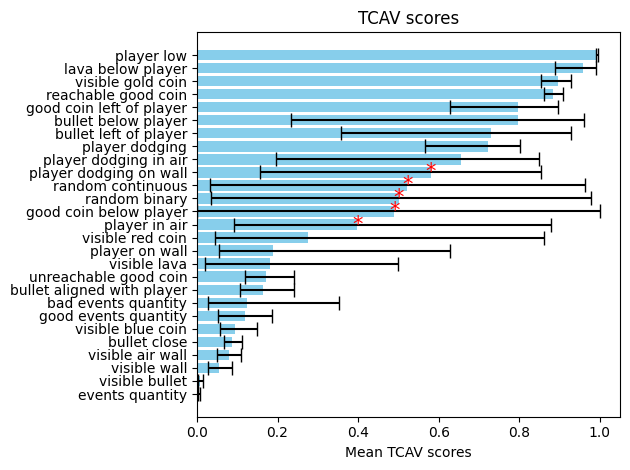

In [13]:
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)

# Splitting the data
concepts = [item[0] for item in data_sorted]
means = [item[1] for item in data_sorted]
low_cis = [item[2] for item in data_sorted]
high_cis = [item[3] for item in data_sorted]
significance = [item[4] for item in data_sorted]
action_means = [item[5] for item in data_sorted]

fig, ax = plt.subplots()
y_pos = np.arange(len(concepts))

errors = [(means[i] - low_cis[i], high_cis[i] - means[i]) for i in range(len(means))]

bars = ax.barh(y_pos, means, xerr=np.array(errors).T, align='center', color='skyblue', ecolor='black', capsize=5)

# Adding a star for non-significant concepts
for bar, sig in zip(bars, significance):
    if not sig:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, '*', ha='center', va='center', color='red', fontsize=15)

# Setting labels and title
ax.set_yticks(y_pos)
ax.set_yticklabels(concepts)
ax.set_xlabel('Mean TCAV scores')
ax.set_title('TCAV scores')

plt.gca().invert_yaxis()  # Invert y-axis to have the highest mean at the top
plt.tight_layout()
plt.show()

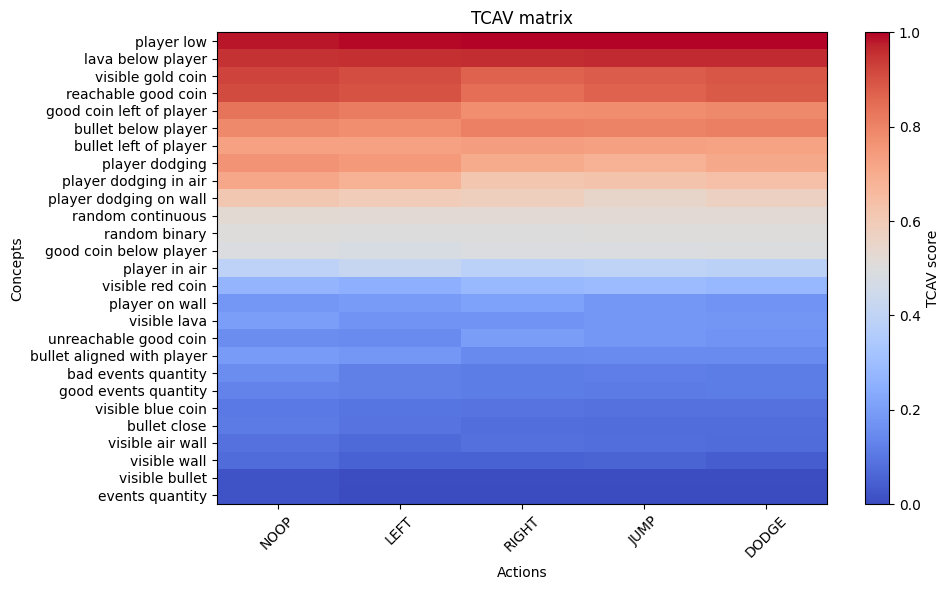

In [14]:
matrix = np.array(action_means)

# Calculate the maximum mean gradient value for each concept and get sorted indices
sorted_indices = np.argsort(-matrix.mean(axis=1))
sorted_matrix = matrix[sorted_indices]
sorted_concept_names = np.array(concepts)[sorted_indices]

# Plotting the sorted matrix
plt.figure(figsize=(10, 6))
plt.imshow(sorted_matrix, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='TCAV score')
plt.xticks(np.arange(len(actions)), actions, rotation=45)
plt.yticks(np.arange(len(sorted_concept_names)), sorted_concept_names)
plt.title('TCAV matrix')
plt.xlabel('Actions')
plt.ylabel('Concepts')
plt.tight_layout()
#plt.savefig('figures/conceptual sensitivity/concept-action-mean.png')
plt.show()

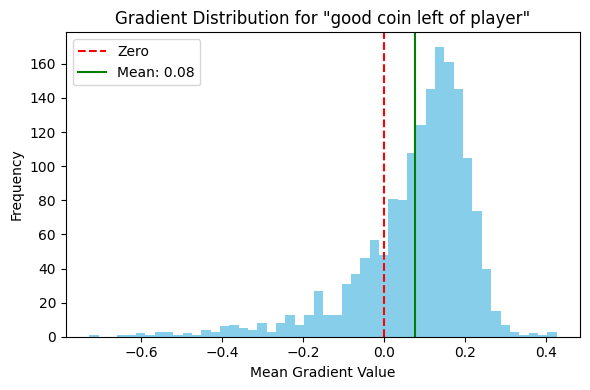

In [15]:
concept = concept_instances['good coin left of player']

gradients = get_gradients(concept, get_cav(concept))
gradients = gradients.mean(dim=1).detach().cpu().numpy()
mean_value = np.mean(gradients)
plt.figure(figsize=(6, 4))
plt.hist(gradients, bins=50, color='skyblue')
plt.xlabel('Mean Gradient Value')
plt.ylabel('Frequency')
plt.title(f'Gradient Distribution for "{concept.name}"')

plt.axvline(x=0, color='r', linestyle='--', label='Zero')
plt.axvline(x=mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.2f}')
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
'''
for i in range(len(actions)):
    plt.hist(gradients[:, i], bins=50)
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.title(f'Gradient Distribution for action "{actions[i]}"')
    plt.axvline(x=0, color='r', linestyle='--', label='Zero')
    plt.tight_layout()
    plt.legend()
    plt.show()
    plt.clf()
'''

'\nfor i in range(len(actions)):\n    plt.hist(gradients[:, i], bins=50)\n    plt.xlabel(\'Gradient Value\')\n    plt.ylabel(\'Frequency\')\n    plt.title(f\'Gradient Distribution for action "{actions[i]}"\')\n    plt.axvline(x=0, color=\'r\', linestyle=\'--\', label=\'Zero\')\n    plt.tight_layout()\n    plt.legend()\n    plt.show()\n    plt.clf()\n'